In [1]:
import pandas as pd
import numpy as np

conf = pd.read_parquet('../data/integrated/GANSLIDER_CONFIGS_FLAT.parquet')
conf = conf[['taskid', 'slider_id', 'target_value']].drop_duplicates()

df = pd.read_parquet('../data/integrated/GANSLIDER_INTERACTIONS_CONSOLIDATED.parquet')

df = df.merge(conf, on=['taskid', 'slider_id'], validate='many_to_one')
df['abs_deviation'] = (df['target_value'].astype(float) - df['last_edit_value'].astype(float)).abs()
df.sort_values(['taskid', 'start'])


,taskid,key,slider_id,last_edit_value,first_edit_value,changed_slider_id,start,end,edit_value_count,distinct_edit_values,action_type,PROLIFIC_PID,num_sliders,slider_type,GROUP,completed,target_value,abs_deviation
148727,0024922e-53cb-43ce-9e3d-746bac2ad866,1626975595217_START,0,0.0,0.0,START,1626975595217,1626975595350,11,1,CLICK,60f9178bf158140ffcd6ecf8,10,FILMSTRIP,B,DONE,2.0,2.0
148815,0024922e-53cb-43ce-9e3d-746bac2ad866,1626975595217_START,1,0.0,0.0,START,1626975595217,1626975595350,11,1,CLICK,60f9178bf158140ffcd6ecf8,10,FILMSTRIP,B,DONE,4.4,4.4
148903,0024922e-53cb-43ce-9e3d-746bac2ad866,1626975595217_START,2,0.0,0.0,START,1626975595217,1626975595350,11,1,CLICK,60f9178bf158140ffcd6ecf8,10,FILMSTRIP,B,DONE,-0.6,0.6
148991,0024922e-53cb-43ce-9e3d-746bac2ad866,1626975595217_START,3,0.0,0.0,START,1626975595217,1626975595350,11,1,CLICK,60f9178bf158140ffcd6ecf8,10,FILMSTRIP,B,DONE,1.6,1.6
149079,0024922e-53cb-43ce-9e3d-746bac2ad866,1626975595217_START,4,0.0,0.0,START,1626975595217,1626975595350,11,1,CLICK,60f9178bf158140ffcd6ecf8,10,FILMSTRIP,B,DONE,-1.6,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201000,ffb40708-446e-4faa-a5c3-2fde69e7fc1f,1628691149948_0,3,-2.0,-2.0,0,1628691149948,1628691150759,14,1,DRAG,6109907b6f1fe1d30a251e7e,8,FILMSTRIP,A,DONE,-4.6,2.6
201065,ffb40708-446e-4faa-a5c3-2fde69e7fc1f,1628691149948_0,4,-4.0,-4.0,0,1628691149948,1628691150759,14,1,DRAG,6109907b6f1fe1d30a251e7e,8,FILMSTRIP,A,DONE,-1.5,2.5
201130,ffb40708-446e-4faa-a5c3-2fde69e7fc1f,1628691149948_0,5,-1.9,-1.9,0,1628691149948,1628691150759,14,1,DRAG,6109907b6f1fe1d30a251e7e,8,FILMSTRIP,A,DONE,-1.0,0.9
201195,ffb40708-446e-4faa-a5c3-2fde69e7fc1f,1628691149948_0,6,0.2,0.2,0,1628691149948,1628691150759,14,1,DRAG,6109907b6f1fe1d30a251e7e,8,FILMSTRIP,A,DONE,2.7,2.5


In [2]:
# ids = df[['PROLIFIC_PID', 'taskid', 'num_sliders', 'slider_type', 'start', 'changed_slider_id']].drop_duplicates().sort_values(['PROLIFIC_PID', 'taskid', 'start'])
# ids.to_csv('../changed_slider_ids.csv')

In [3]:
def normalize(grp):
	try:
		grp['start'] = pd.to_datetime(grp['start'].astype(int), unit='ms')
		
		res = grp.sort_values('start')
		first_entries = res[res.start == res.start.min()].copy()
		first_entries['abs_deviation'] = first_entries['target_value'].astype(float).abs()
		first_entries['start'] = first_entries['start'] - pd.Timedelta('11 ms')

		res = res.append(first_entries)

		res['start'] = res['start'] - res['start'].min()
		res['start'] = res['start'] / res['start'].max()
		res['start'] = pd.to_timedelta(res['start'], unit='seconds')

		res['slider_id'] = res['slider_id'].astype(int)
		res['abs_deviation'] = res['abs_deviation'].astype(float)

		res = (res
			.set_index('start')
			.resample('10 ms', origin='start')[['slider_id', 'abs_deviation']]
			.apply(lambda arr: pd.DataFrame(arr).groupby('slider_id').mean().sum(skipna=False, min_count=1))
			.ffill()
		)

		return res
	except ZeroDivisionError as e:
		return None


tmpDF = df.groupby(['taskid', 'num_sliders', 'slider_type', 'completed']).apply(normalize)
tmpDF

abs_deviation
taskid                               num_sliders slider_type completed start                                
0024922e-53cb-43ce-9e3d-746bac2ad866 10          FILMSTRIP   DONE      0 days 00:00:00                25.025
                                                                       0 days 00:00:00.010000         25.025
                                                                       0 days 00:00:00.020000         25.025
                                                                       0 days 00:00:00.030000         25.025
                                                                       0 days 00:00:00.040000         23.150
...                                                                                                      ...
ffb40708-446e-4faa-a5c3-2fde69e7fc1f 8           FILMSTRIP   DONE      0 days 00:00:00.960000         21.700
                                                                       0 days 00:00:00.970000         21.700
                                                                       0 days 00:00:00.980000         22.200
                                                                       0 days 00:00:00.990000         23.100
                                                                       0 days 00:00:01                24.200

[193617 rows x 1 columns]

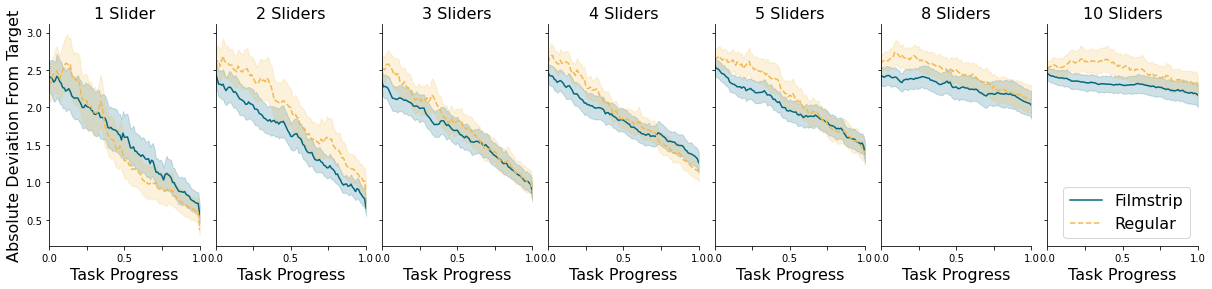

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib

matplotlib.rc('pdf', fonttype=42)

toplot = tmpDF.reset_index()
toplot = toplot.rename(columns={'start': 'ts'})
toplot['ts'] = toplot['ts'].dt.total_seconds()
toplot['abs_deviation'] = toplot['abs_deviation'] / toplot['num_sliders']
toplot['slider_type'] = toplot['slider_type'].apply(lambda val: val.lower().capitalize())


kw = {'color': ["#04677E", "#F3B94E" ], 'linestyle' : ["-","--"]}

grid = sns.FacetGrid(data=toplot[toplot.completed == 'DONE'], col="num_sliders", hue="slider_type", hue_kws=kw, margin_titles=True, height=4, aspect=.6)
g = grid.map_dataframe(sns.lineplot, "ts", 'abs_deviation')

for i, ax in enumerate(g.axes.flatten()):
	if i == 0:
		ax.set_ylabel("Absolute Deviation From Target")

	title = ax.get_title()
	title = title.replace('num_sliders = ', '') + ( " Slider" if i == 0 else " Sliders")
	ax.set_title(title, fontsize=16)
	ax.set_xlabel("Task Progress", fontsize=16)
	ax.set_ylabel(ax.get_ylabel(), fontsize=16)
	ax.set_xlim((0, 1))
	ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
	ax.set_xticklabels(["0.0", "", "0.5", "", "1.0"])

ax.legend(loc='lower right', ncol=1, fontsize=16)

plt.savefig(f'../images/Figure4_absolute_deviation_over_time.pdf', bbox_inches="tight")


# grid = sns.FacetGrid(data=toplot[toplot.completed == 'GIVEUP'], col="num_sliders", hue="slider_type")
# grid.map_dataframe(sns.lineplot, x="ts", y='abs_deviation')
# grid.add_legend()